In [1]:
%pwd

'C:\\Users\\User\\Desktop\\Programming\\Python\\DSC680\\Final Project1'

In [2]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN

In [3]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [4]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

#generation the data array containing 881 rows and 20551 columns
data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

#generation and array of true sample labels
true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)

In [5]:
#checking the first 5 rows and 3 columns in the data array
data[:5, :3]


array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

In [6]:
#shape of the data array
data.shape

(801, 20531)

In [7]:
#type of the data array
type(data)

numpy.ndarray

In [8]:
#the first 5 true label names
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

In [9]:
#generation an LabelEncoder object
label_encoder = LabelEncoder()

#converting true labels into numbers
true_labels = label_encoder.fit_transform(true_label_names)
#checking the first 5 true labels converting to numbers
true_labels[:5]

array([4, 3, 4, 4, 0], dtype=int64)

In [10]:
#checking the number of classes in the dataset
label_encoder.classes_

n_clusters = len(label_encoder.classes_)
n_clusters

5

### Selecting an optimal k value for KMeans

In [11]:
#generation of the df_pca dataframe where 20551 featured were reduced to two principal components
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data)
pca = PCA(n_components=2)
pca=pca.fit_transform(scaled_features)
df_pca=pd.DataFrame(data=pca, columns=["principal_componemt1", "principal_component2"])
df_pca

,principal_componemt1,principal_component2
0,-5.668141,-8.872139
1,-1.470204,10.280182
2,-10.845387,-1.345352
3,-9.167961,-8.670123
4,-6.271848,-3.101208
...,...,...
796,-5.157837,-4.843212
797,-2.673758,4.721151
798,0.741083,3.543644
799,-4.771717,-9.853142


In [12]:
# """The elbow method was used to select an optimal k value.
# To perform the elbow method, several k-means runs with values ranging from 1 to 10 were performed:"""

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 1000,
}

# A list holds the wss values for each k
wss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    wss.append(kmeans.inertia_)

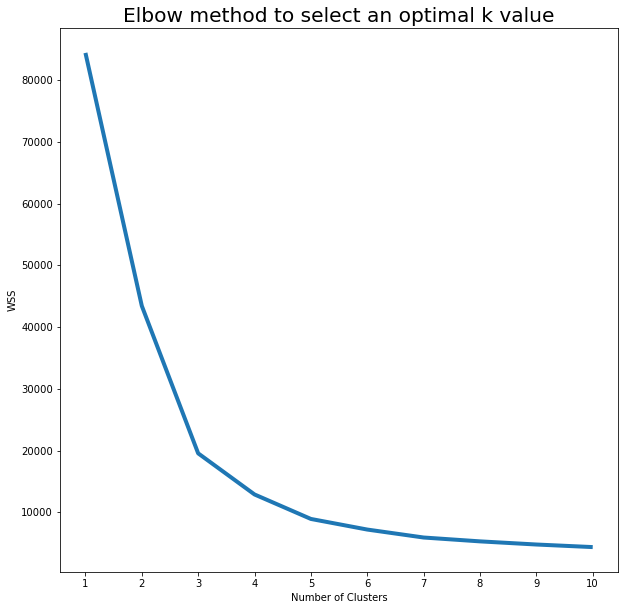

In [13]:
#visualizing the graph cost function vs k-values for the K Means
%matplotlib inline
fig=plt.figure(figsize=(10, 10))
# plt.rcParams["figure.figsize"]=(10, 10)
ax=fig.add_subplot()
plt.style.use("fivethirtyeight")
ax.plot(range(1, 11), wss)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("WSS")
plt.title("Elbow method to select an optimal k value")
plt.savefig("Elbow k-means")
plt.show()

In [36]:
#generation the preprocessor pipeline object
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=1000)),
    ]
)

In [38]:
#generation the clusterer pipeline object
clusterer = Pipeline(
   [ (
         "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=1000)) ])

In [39]:
#generation the pipe_kmeans pipeline object including both preprocessor and clusterer pipeline objects
pipe_kmeans = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [40]:
#fitting the data array to the pipe_kmeans pipeline object
pipe_kmeans.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=1000))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=1000))]))])

In [41]:
#generation of preprocessed data scaled using MinMaxScaler
preprocessed_data = pipe_kmeans["preprocessor"].transform(data)

predicted_labels = pipe_kmeans["clusterer"]["kmeans"].labels_
#calculating the silhouette score for the k menans
silhouette_score(preprocessed_data, predicted_labels)

0.5118775531953308

In [42]:
#calculating the adjusted rand score for the k menans
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

In [43]:
"""generation of the df_kmeans dataframe containing the preprocessed values using MinMaxScaler and the number
of features was reduced to two by PCA.
"""
df_kmeans = pd.DataFrame(
    pipe_kmeans["preprocessor"].transform(data),
    columns=["component1", "component2"],
)

#adding two columns to the df_kmeans data frame-predicted_cluster and true_cluster
df_kmeans["predicted_cluster"] = pipe_kmeans["clusterer"]["kmeans"].labels_
df_kmeans["true_cluster"] = label_encoder.inverse_transform(true_labels)

C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


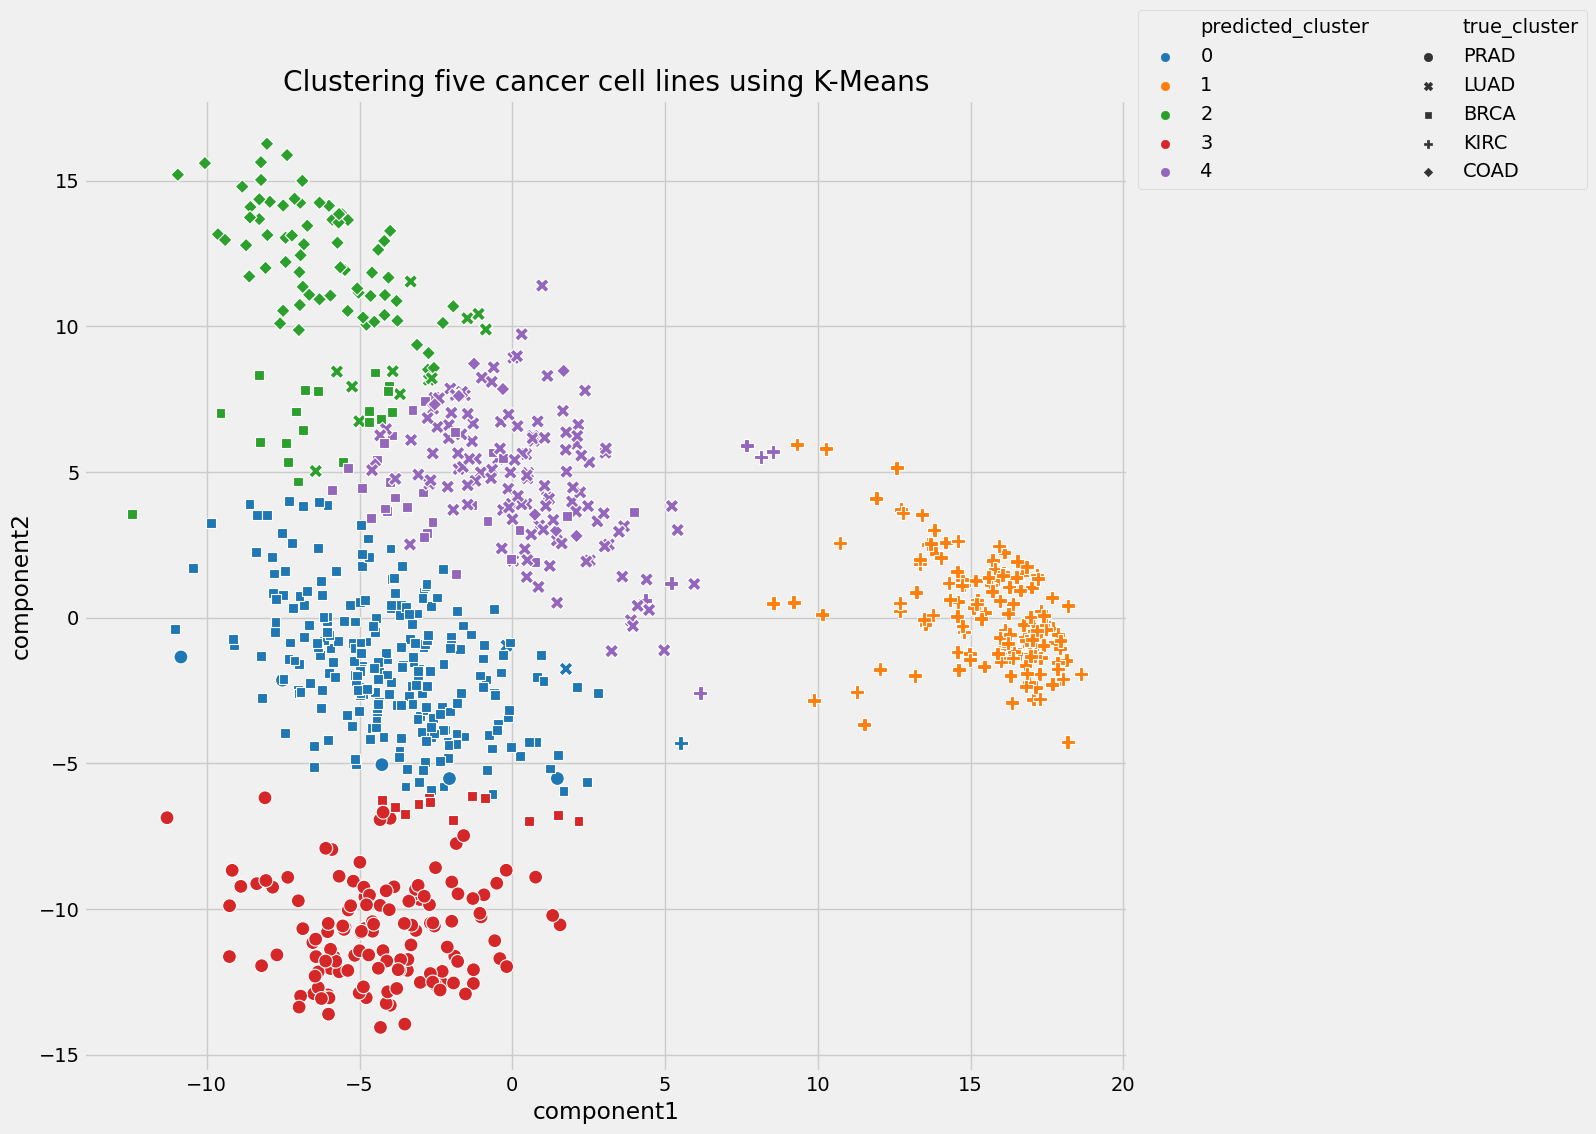

In [44]:
# visualization of the k_means clustering algorithm

plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 12))

ax= sns.scatterplot(
    "component1",
    "component2",
    s=100,
    data=df_kmeans,
    hue="predicted_cluster",
    style="true_cluster",
    palette="tab10",
)

ax.set_title(
    "Clustering five cancer cell lines using K-Means"
)
plt.legend(bbox_to_anchor=(1, 1), loc=6, ncol=2)
plt.savefig("clusterin K-Means")

plt.show()

In [45]:
"""generation of the df_kmeans dataframe containing the preprocessed values using MinMaxScaler and the number
of features was reduced to two by PCA.
"""
df_dbscan = pd.DataFrame(
    pipe_kmeans["preprocessor"].transform(data),
    columns=["component1", "component2"],
)

df_dbscan.shape

(801, 2)

In [46]:
""" calculation of distances for the 4 nearest neighbors for each sample"""
min_samples=df_dbscan.shape[1]*2
k=min_samples if min_samples>2 else 2
nbrs=NearestNeighbors(n_neighbors=k).fit(df_dbscan)
distances, indices=nbrs.kneighbors(df_dbscan)

In [47]:
#printing out the first 5 rows of the distances array
print("min samples: "+str(min_samples))
print("shape of distance matrix "+ ": ", distances.shape)
print(type(distances[:5]))
for enum, i in enumerate(distances[:5]):
    print("observation " +str(enum) + ": ", [round(x, 2) for x in i])

min samples: 4
shape of distance matrix :  (801, 4)
<class 'numpy.ndarray'>
observation 0:  [0.0, 0.49, 0.83, 0.89]
observation 1:  [0.0, 0.4, 0.62, 0.72]
observation 2:  [0.0, 0.98, 1.79, 1.81]
observation 3:  [0.0, 0.62, 0.93, 1.16]
observation 4:  [0.0, 0.62, 0.87, 0.88]


In [48]:
"""The last cell of each row represents the distance of the k-th farthest point
adding the new column-knn_dist"""

df_dbscan["knn_dist"]=distances[:, -1]
df_dbscan.head()

,component1,component2,knn_dist
0,-5.668141,-8.872139,0.894044
1,-1.470204,10.280182,0.717011
2,-10.845387,-1.345352,1.807476
3,-9.167961,-8.670123,1.158364
4,-6.271848,-3.101208,0.879508


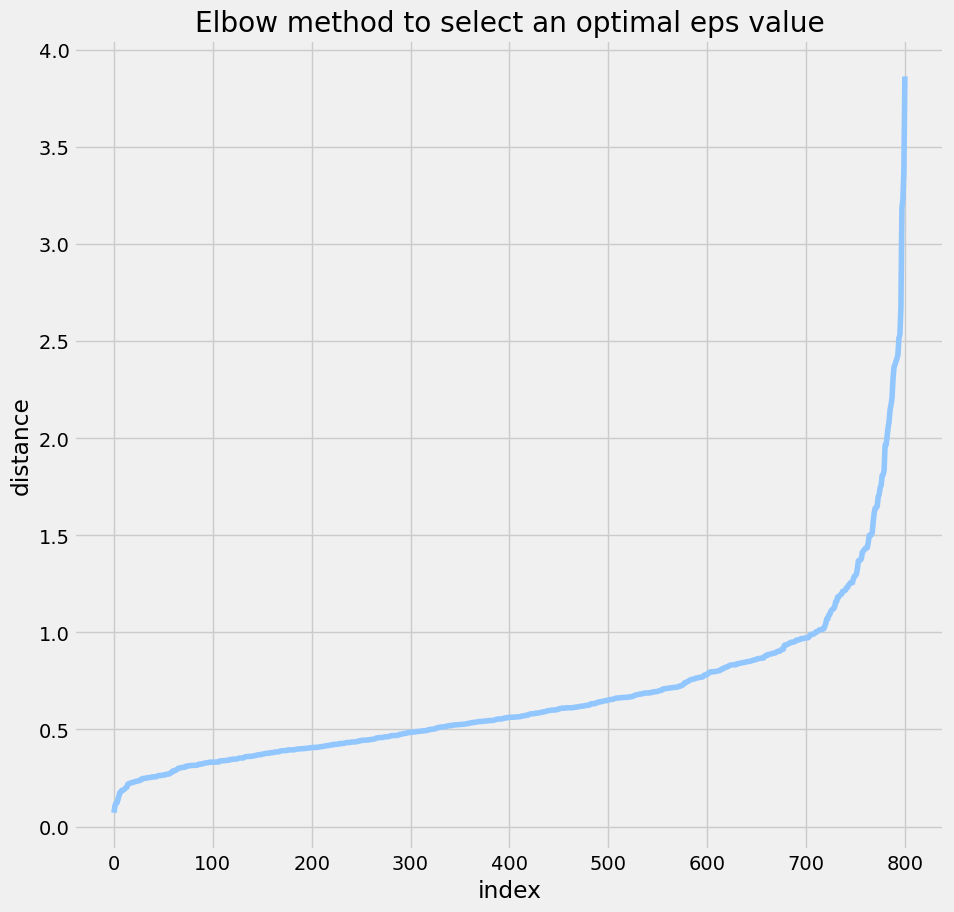

In [49]:
plt.rcParams["figure.figsize"]=(10, 10)
plt.style.use("seaborn-pastel")
df_dbscan.sort_values("knn_dist").reset_index()[["knn_dist"]].plot(legend=False)
plt.title("Elbow method to select an optimal eps value")
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(True)
plt.savefig("Elbow DBSCAN")
plt.show()
plt.rcdefaults()

In [50]:
#generation the preprocessor pipeline object
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=1000)),
    ]
)

In [51]:
#generation the clusterer_dbscan pipeline object 
clusterer_dbscan = Pipeline(
    [
        ("dbscan", DBSCAN(eps=1.5, min_samples=15),),
    ]
)

In [52]:
#generation of the pipe_dbscan pipeline object including both the preprocessor pipeline object and the clusterer_dbscan pipeline object
pipe_dbscan = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer_dbscan", clusterer_dbscan)
    ]
)

In [53]:
#fitting the data to the pipe_dbscan object
pipe_dbscan.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=1000))])),
                ('clusterer_dbscan',
                 Pipeline(steps=[('dbscan',
                                  DBSCAN(eps=1.5, min_samples=15))]))])

In [54]:
# transformation  the data dataframe using the preprocessor pipeline object 
preprocessed_data = pipe_dbscan["preprocessor"].transform(data)
#generation of predicted labels
predicted_labels = pipe_dbscan["clusterer_dbscan"]["dbscan"].labels_

# silhouette_score(preprocessed_data, predicted_labels)
np.unique(predicted_labels)

array([-1,  0,  1,  2,  3], dtype=int64)

In [55]:
#calculation the sihouette score for the DBSCAN algorithm
silhouette_score(preprocessed_data, predicted_labels)

0.3792711970865879

In [56]:
#calculation of the adjusted rand score for the DBSCAN algorithm
adjusted_rand_score(true_labels, predicted_labels)

0.5329823611593871

In [57]:
#adding two columns to the df_dbscan dataframe-predicted_cluster and true_cluster
df_dbscan["predicted_cluster"] = pipe_dbscan["clusterer_dbscan"]["dbscan"].labels_
df_dbscan["true_cluster"] = label_encoder.inverse_transform(true_labels)

df_dbscan.head()


,component1,component2,knn_dist,predicted_cluster,true_cluster
0,-5.668141,-8.872139,0.894044,1,PRAD
1,-1.470204,10.280182,0.717011,-1,LUAD
2,-10.845387,-1.345352,1.807476,-1,PRAD
3,-9.167961,-8.670123,1.158364,-1,PRAD
4,-6.271848,-3.101208,0.879508,0,BRCA


C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


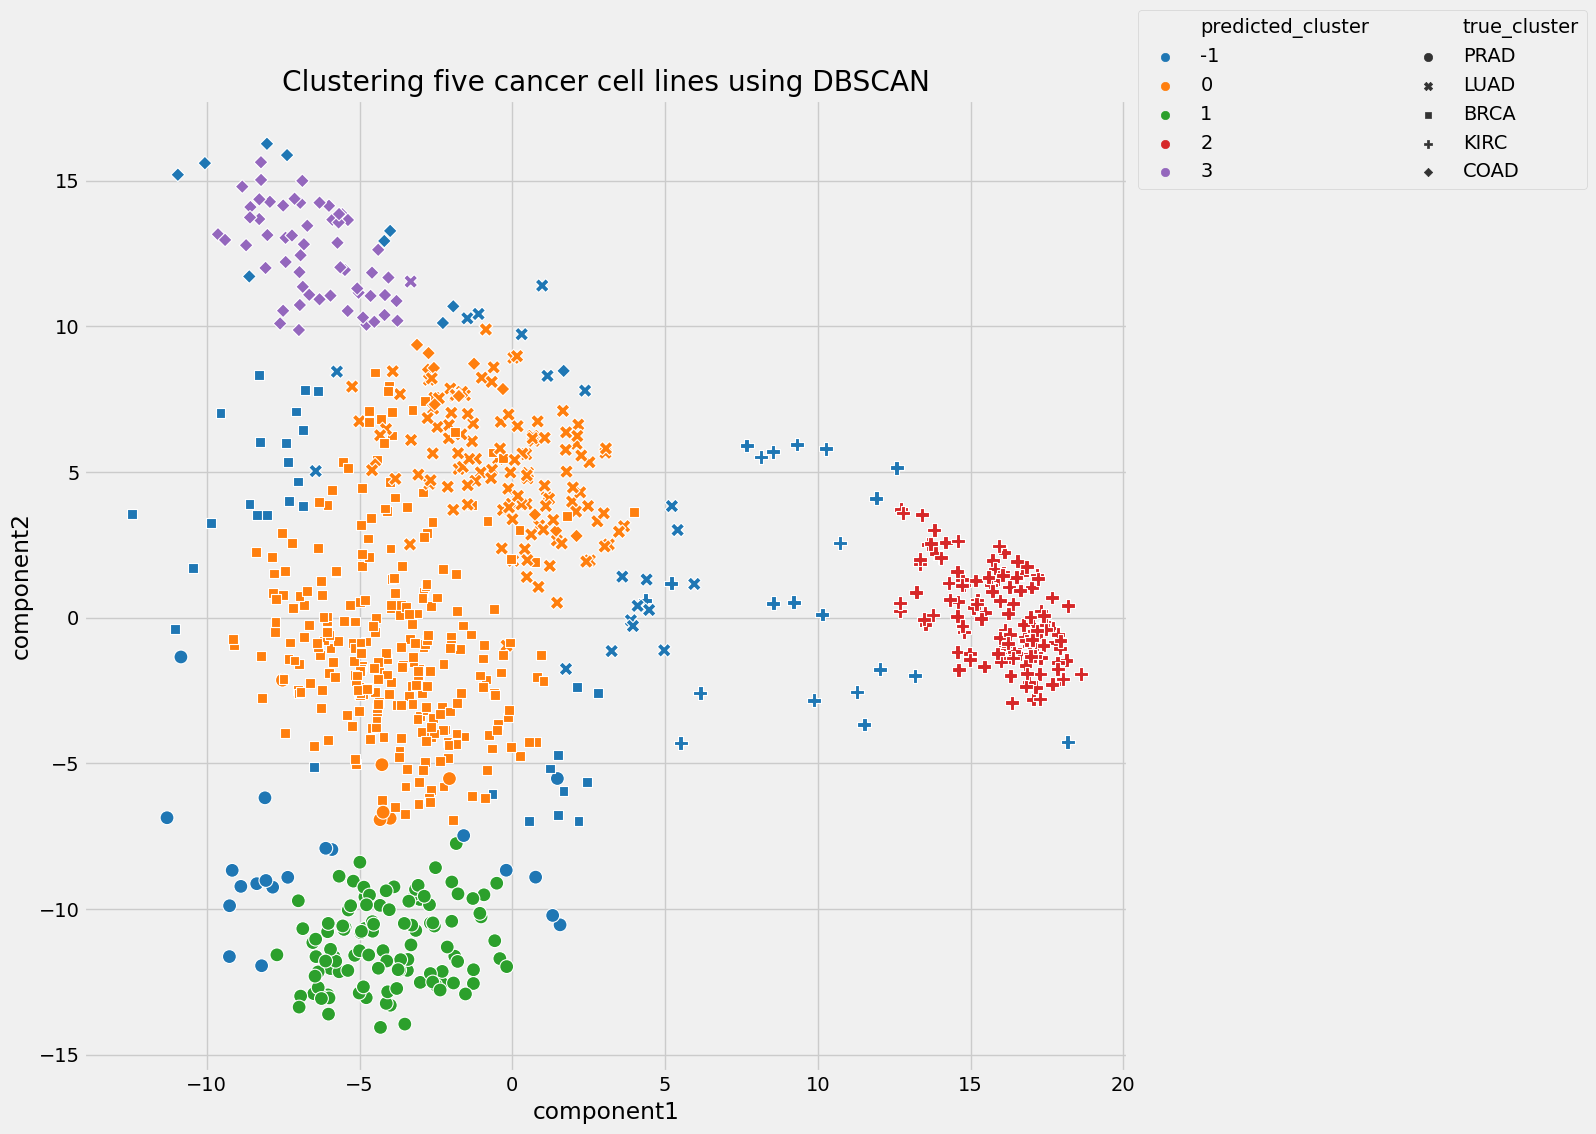

In [58]:
#visualization of the DBSCAN clustering algorithm
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 12))

ax = sns.scatterplot(
    "component1",
    "component2",
    s=100,
    data=df_dbscan,
    hue="predicted_cluster",
    style="true_cluster",
    palette="tab10",
)

ax.set_title(
    "Clustering five cancer cell lines using DBSCAN"
)
plt.legend(bbox_to_anchor=(1, 1), ncol=2, loc=6)
plt.savefig("clustering DBSCAN")

plt.show()